In [48]:
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

In [1]:
from matplotlib_scalebar.scalebar import ScaleBar

# Sensitivity of ASO Snow cover mask to snow depth threshold
David Shean

May 2, 2020

_(modified by Tony Cannistra, Jan 30, 2020)_

**Purpose**: Examine the choice of snow depth threshold used to binarize 3 m ASO snow depth data.


In [3]:
aso_sd_fn = '/Volumes/wrangell-st-elias/research/planet/ASO_3M_SD_USCATE_20180528.tif'

In [4]:
aso_sd_ds = rio.open(aso_sd_fn)
aso_sd = aso_sd_ds.read(1, masked=True)

In [132]:
def imshow_stretch(ax,a,clim=None,perc=(2,98),sym=False,cmap='inferno',dx=aso_sd_ds.res[0],cbar=True):
    if sym:
        cmap = 'RdBu'
    if clim is None:
        vmin,vmax = np.percentile(a.compressed(),perc)
        #vmin,vmax = np.percentile(a,perc)
        if sym:
            vmax = np.max(np.abs([vmin,vmax]))
            vmin = -vmax
        clim = (vmin, vmax)
    m = ax.imshow(a, vmin=clim[0], vmax=clim[1], cmap=cmap, interpolation='None')
    ax.add_artist(ScaleBar(dx))
    cbar_obj=None
    if cbar:
        cbar_obj = plt.colorbar(m, ax=ax)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_facecolor('0.5')
    return clim, cbar_obj

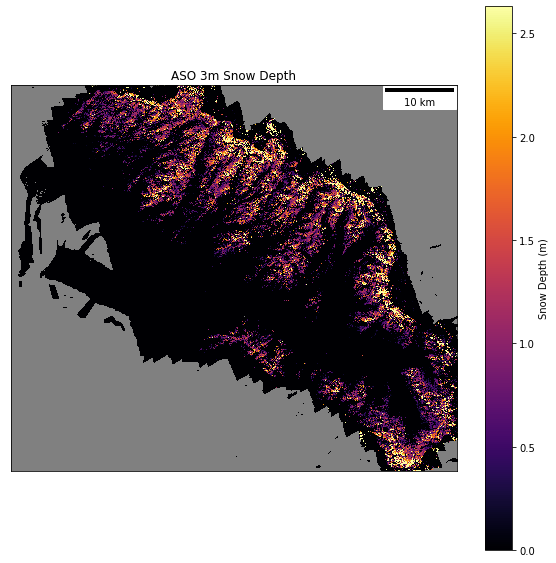

In [8]:
f, ax = plt.subplots(figsize=(10,10))
clim, cbar = imshow_stretch(ax, aso_sd)
plt.title("ASO 3m Snow Depth")
cbar.set_label("Snow Depth (m)")

## General Statistics

In [22]:
display.Markdown(f"**Number of snow depth pixels:** {aso_sd.count():.1E}")

**Number of snow depth pixels:** 2.3E+08

In [23]:
display.Markdown(f"**Maxiumum snow depth**: {aso_sd.max():.2f}m")

**Maxiumum snow depth**: 24.89m

In [25]:
# 1 cm snow depth bins from 1 cm to 300 cm
bins = np.arange(0.01,3.01,0.01)

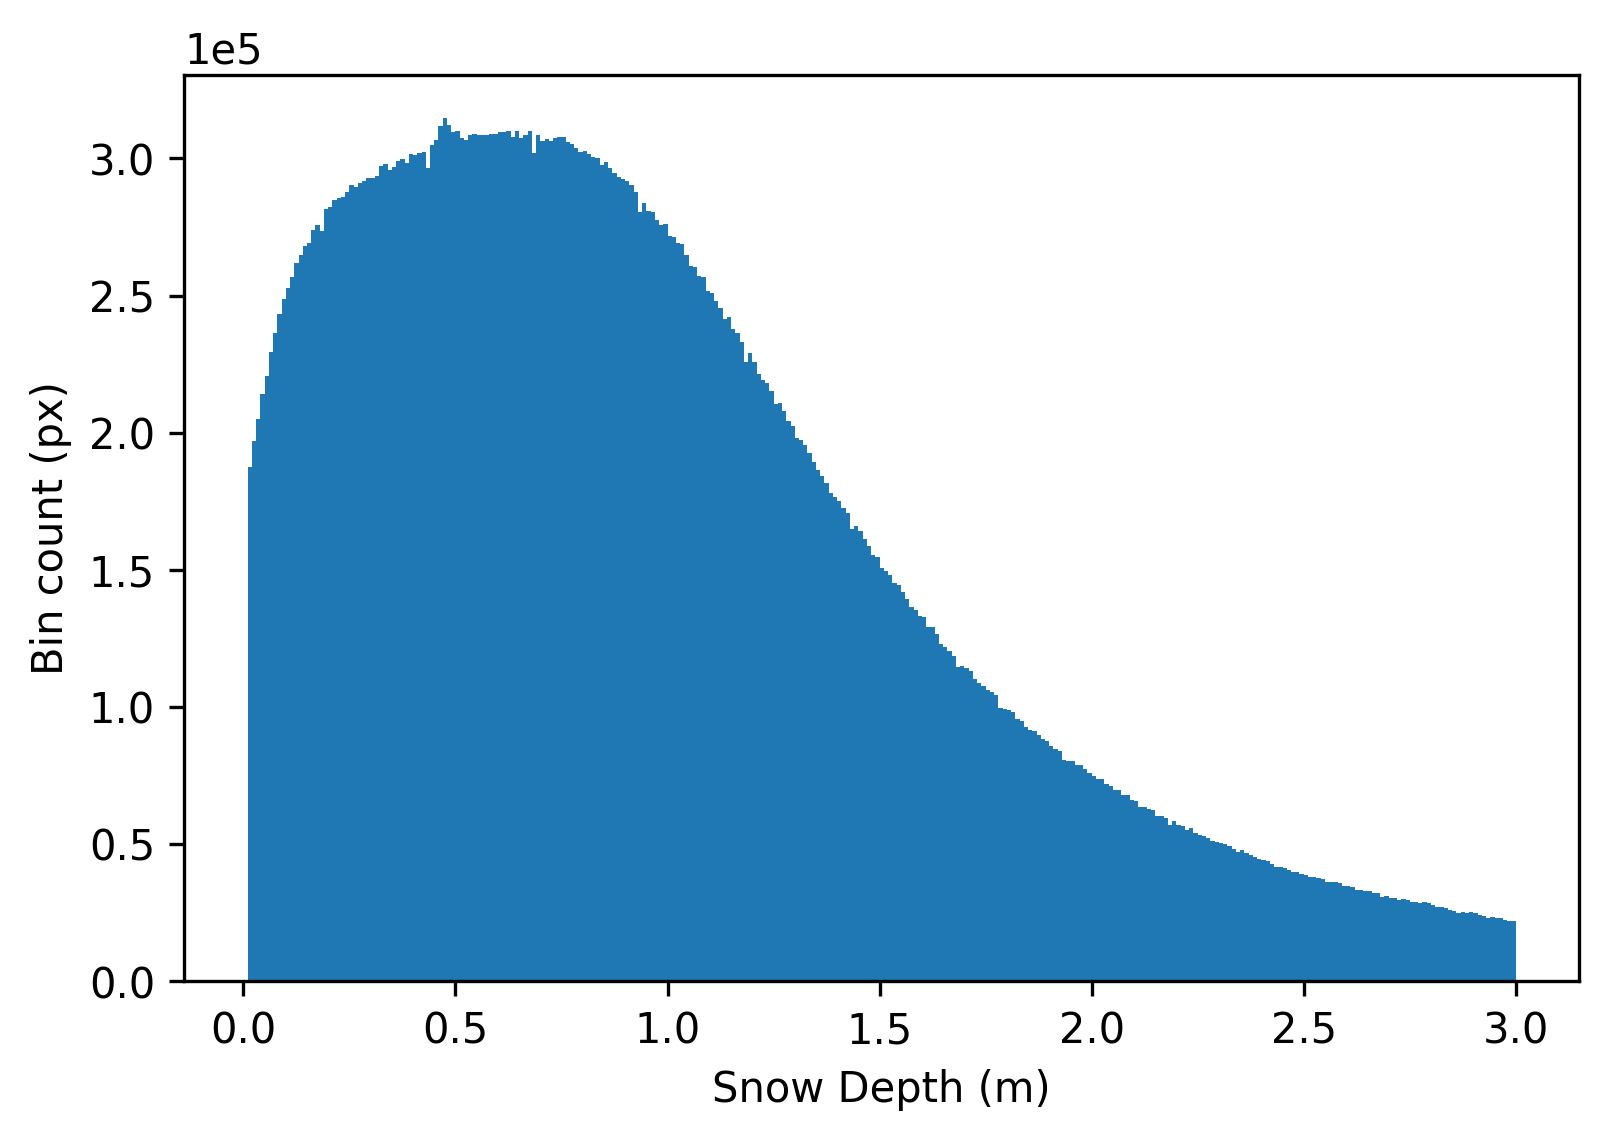

In [49]:
f,ax = plt.subplots(dpi=150)
ax.hist(aso_sd.compressed(), bins=bins)
ax.set_xlabel('Snow Depth (m)')
ax.set_ylabel('Bin count (px)')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))


## Examine the effect of multiple thresholds on binary snow pixel assignment



In [31]:
# Possible thresholds 
# 1 cm to 20 cm in 1 cm increments 
sd_thresh_list = np.arange(0.01, 0.21, 0.01)
sd_thresh_list

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ])

In [32]:
# count the number of pixels >= each threshold
snow_mask_count_list = []
for sd_thresh in sd_thresh_list:
    print(sd_thresh)
    snow_mask = aso_sd >= sd_thresh
    snow_mask_count = snow_mask.sum()
    snow_mask_count_list.append(snow_mask_count)

0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.06999999999999999
0.08
0.09
0.09999999999999999
0.11
0.12
0.13
0.14
0.15000000000000002
0.16
0.17
0.18000000000000002
0.19
0.2


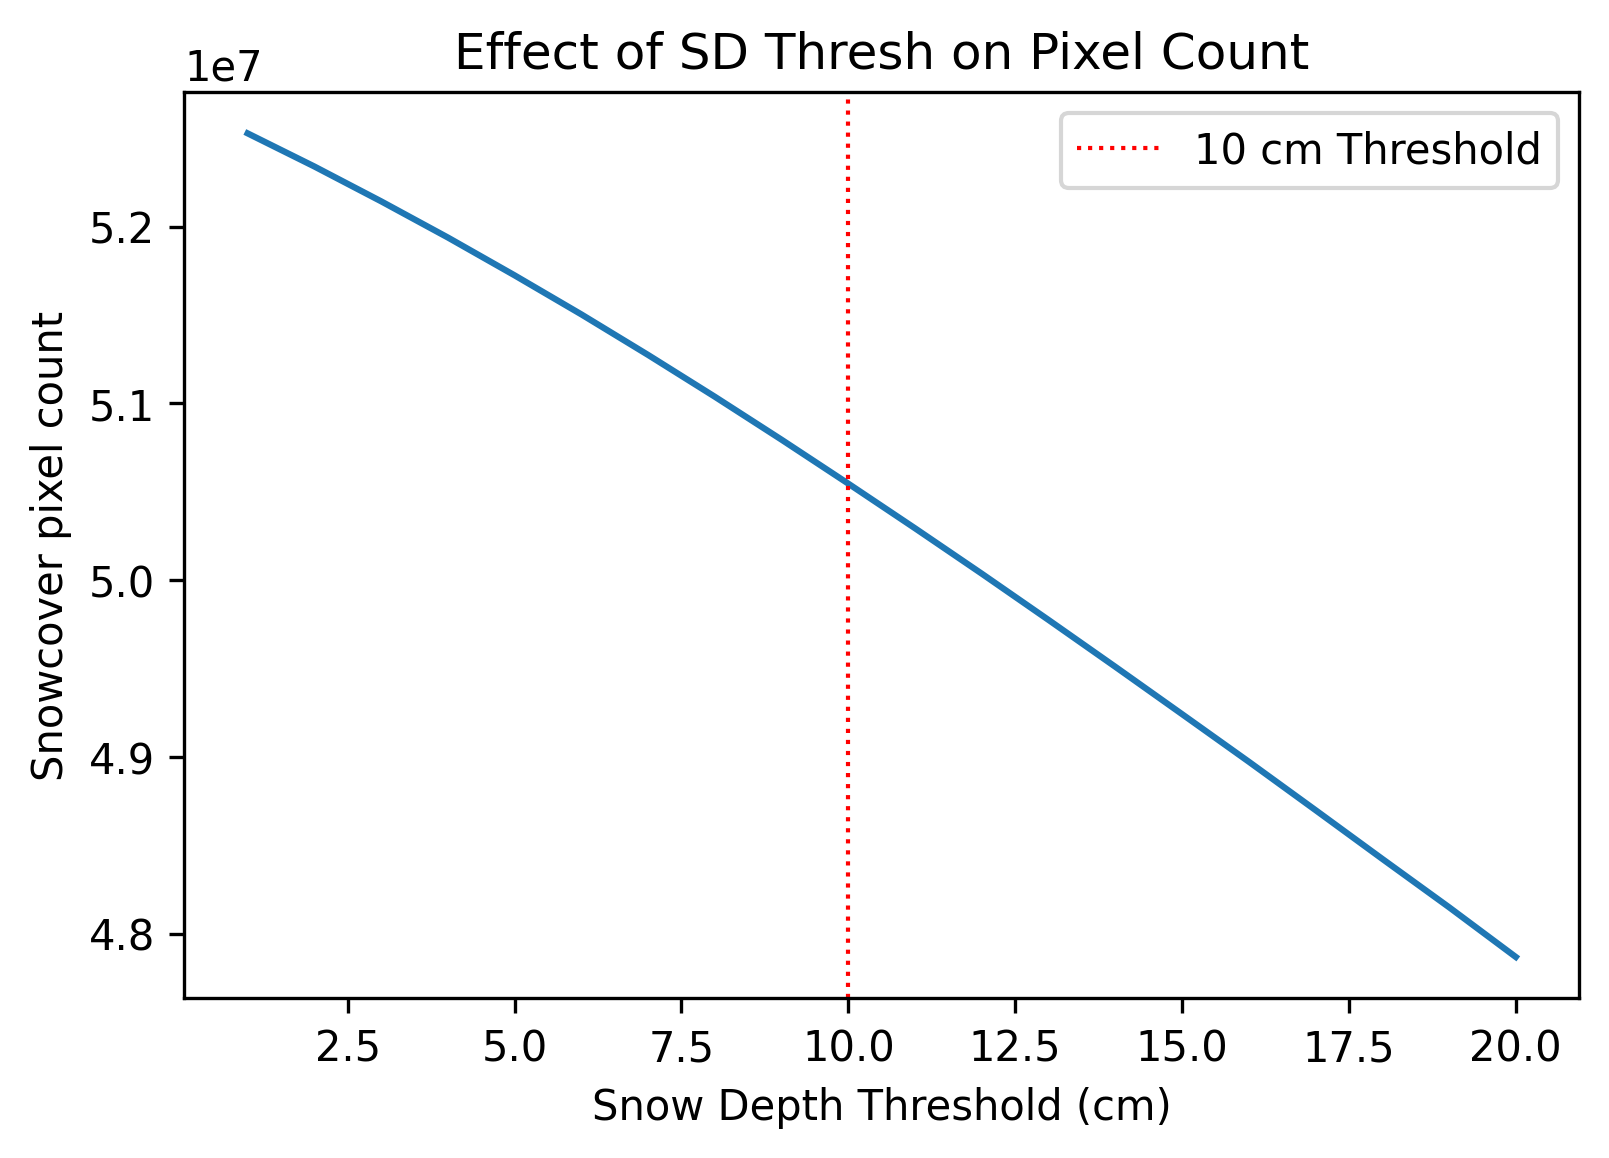

In [65]:
f, ax = plt.subplots(dpi=150)
ax.plot(sd_thresh_list*100, snow_mask_count_list)
ax.set_ylabel('Snowcover pixel count')
ax.set_xlabel('Snow Depth Threshold (cm)')
ax.set_title("Effect of SD Thresh on Pixel Count")
ax.axvline(10.0, linestyle=':', linewidth=1, color='red', label='10 cm Threshold')
plt.legend()

In [52]:
snow_mask_area_list = (np.array(snow_mask_count_list) * aso_sd_ds.res[0] * aso_sd_ds.res[1])/1E6

459.334737

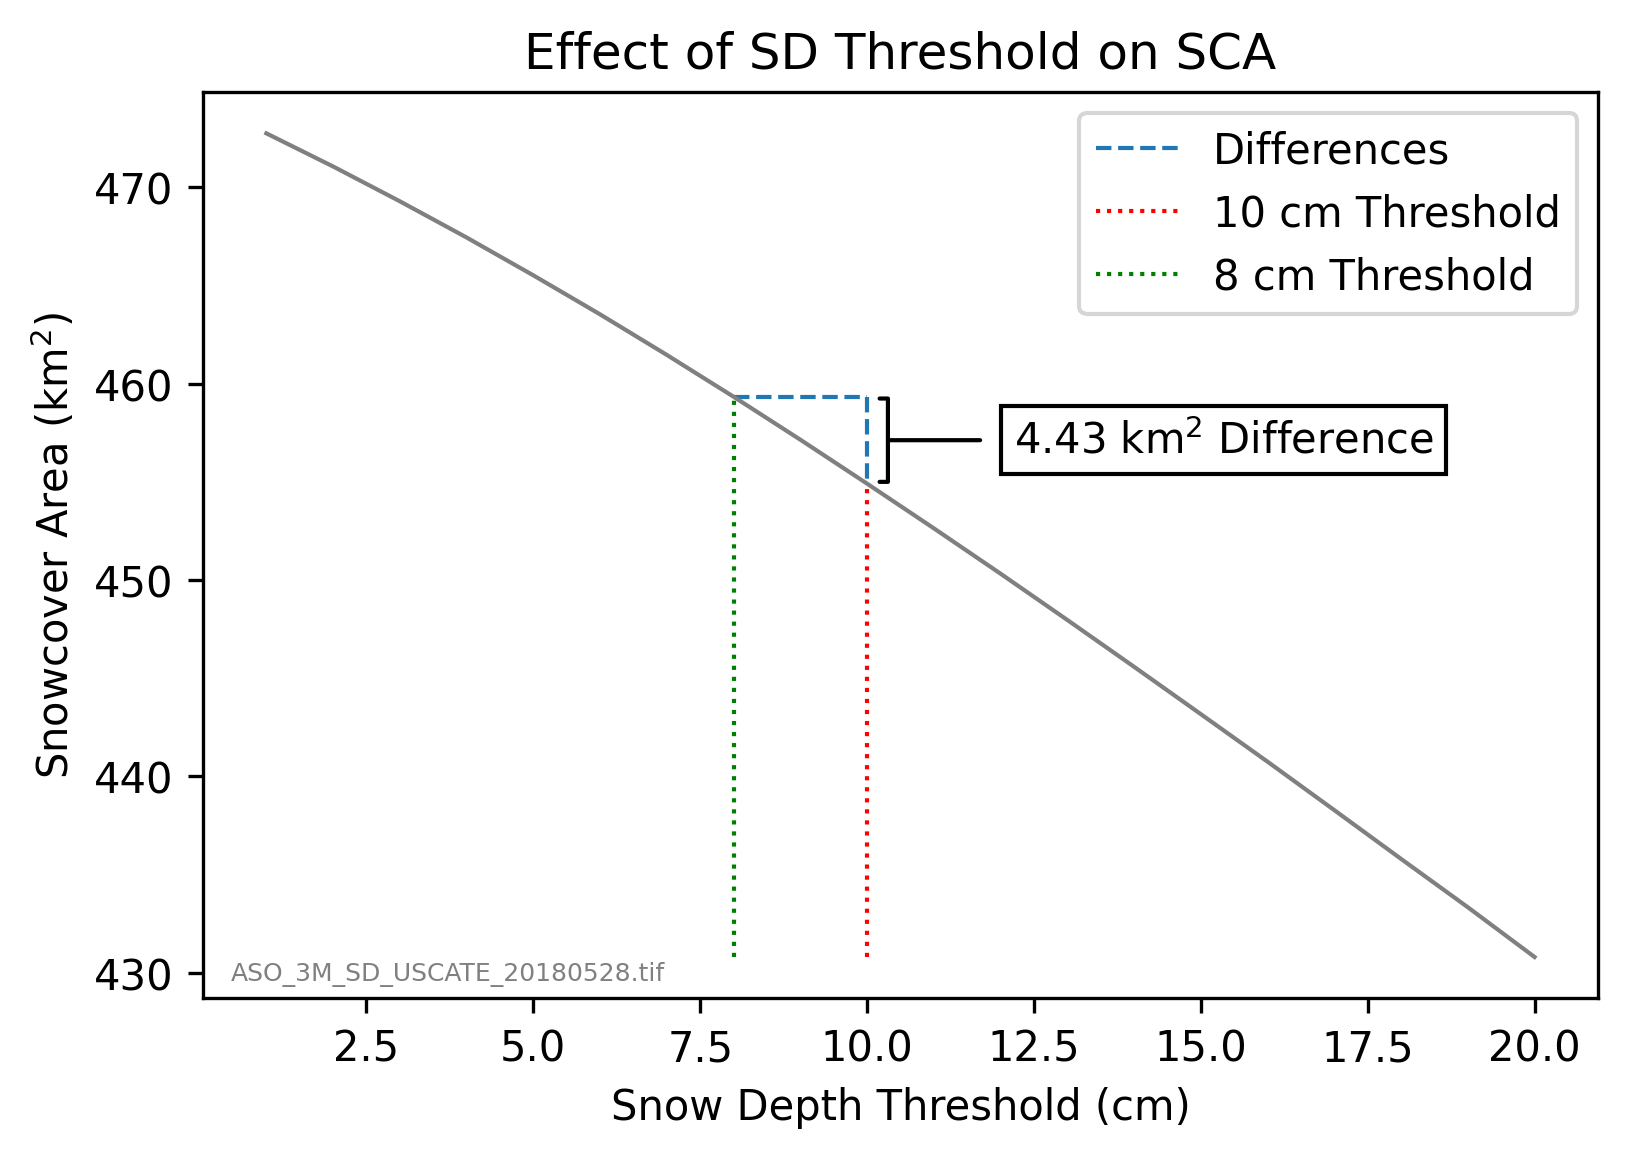

In [231]:
f, ax = plt.subplots(dpi=150)
ax.plot(sd_thresh_list*100, snow_mask_area_list, linewidth=1, color='grey')
ax.set_ylabel('Snowcover Area (km$^2$)')
ax.set_xlabel('Snow Depth Threshold (cm)')
ax.set_title("Effect of SD Threshold on SCA")

#10cm vs 8cm
cm10 = 0.10
cm8 =0.08
cm10_sca = snow_mask_area_list[np.where(np.isclose(sd_thresh_list,cm10))][0]
cm8_sca = snow_mask_area_list[np.where(np.isclose(sd_thresh_list,cm8))][0]

ax.hlines(cm8_sca, cm8*100, cm10*100, linestyle='--', linewidth=1)
ax.vlines(cm10*100, cm8_sca, cm10_sca, linestyle='--', linewidth=1, label='Differences')

bottom = min(snow_mask_area_list)
ax.vlines(cm10*100, bottom, cm10_sca, linestyle=':', linewidth=1, color='red', label=f'{cm10*100:0.0f} cm Threshold')
ax.vlines(cm8*100, bottom, cm8_sca, linestyle=':', linewidth=1, color='green', label=f'{cm8*100:0.0f} cm Threshold')

ax.annotate(f"{(cm8_sca - cm10_sca):.2f} km$^2$ Difference", (cm10*100, cm10_sca + (cm8_sca - cm10_sca)/2),
            (cm10*100 + 2.2, cm10_sca + (cm8_sca - cm10_sca)/2), xycoords='data',
            ha="left", va="center",
            size=10,
            arrowprops=dict(arrowstyle='-[',
                            shrinkA=5,
                            shrinkB=5,
                            fc="k", ec="k",
                            ),
            bbox=dict(boxstyle="square", fc="w"))

ax.annotate('ASO_3M_SD_USCATE_20180528.tif', (0.02, 0.02), xycoords='axes fraction', color='grey', size=6)


plt.legend()

## Visual + Quantitative Comparison of Specific Thresholds

1cm, 10cm and 20cm. 

In [151]:
snow_mask_01cm = aso_sd >= 0.01
snow_mask_08cm = aso_sd >= 0.08
snow_mask_10cm = aso_sd >= 0.10
snow_mask_20cm = aso_sd >= 0.20

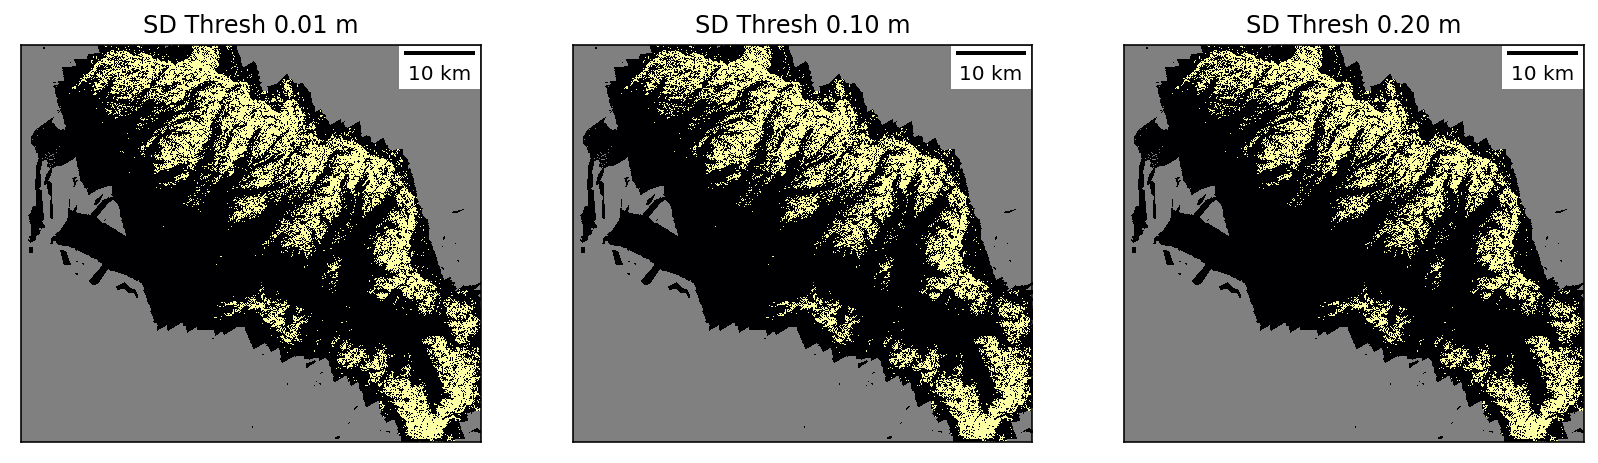

In [135]:
f, axa = plt.subplots(1,3, figsize=(14,8))
imshow_stretch(axa[0], snow_mask_01cm, cbar=False)
imshow_stretch(axa[1], snow_mask_10cm, cbar=False)
imshow_stretch(axa[2], snow_mask_20cm, cbar=False)
axa[0].set_title('SD Thresh %0.2f m' % 0.01);
axa[1].set_title('SD Thresh %0.2f m' % 0.10);
axa[2].set_title('SD Thresh %0.2f m' % 0.20);

In [139]:
def snowmask_comparison(a,b):
    #All valid pixels
    a_all_count = a.count()
    print(a_all_count, "all pixel count in a")
    #All valid snow pixels in a
    a_snow_count = a.sum()
    print(a_snow_count, "snow pixel count in a")
    a_snow_count_perc = 100*a_snow_count/a_all_count
    print("%0.2f%% snow pixel count in a" % a_snow_count_perc)

    #All valid snow pixels in b
    b_snow_count = b.sum()
    print(b_snow_count, "snow pixel count in b")
    b_snow_count_perc = 100*b_snow_count/a_all_count
    print("%0.2f%% snow pixel count in b" % b_snow_count_perc)

    ab_snow_count_diff = np.abs(a_snow_count - b_snow_count)
    print(ab_snow_count_diff, "snow pixel count difference between a and b")
    ab_snow_count_diff_perc = 100*ab_snow_count_diff/np.mean([a_snow_count,b_snow_count])
    #ab_snow_count_diff_perc = 100*ab_snow_count_diff/a_snow_count
    print("%0.2f%% snow pixel count percent difference between a and b" % ab_snow_count_diff_perc)

    #Boolean disagreement for snow
    ab_snow_disagree = ~(a == b)
    #Count of snow pixels that agree
    #print(ab_snow_disagree.sum())
    return ab_snow_disagree

### Percentage Difference in SCA Between Specific Thresholds

**1cm and 10cm**:

In [140]:
snow_mask_01cm_10cm = snowmask_comparison(snow_mask_01cm, snow_mask_10cm)

227623028 all pixel count in a
52527458 snow pixel count in a
23.08% snow pixel count in a
50545392 snow pixel count in b
22.21% snow pixel count in b
1982066 snow pixel count difference between a and b
3.85% snow pixel count percent difference between a and b


In [159]:
display.Markdown(f"_Area Difference: {(1982066 * 3.0 * 3.0) / 1E6:.2f} km$^2$_")

_Area Difference: 17.84 km$^2$_

**8 cm and 10 cm**

In [152]:
snow_mask_01cm_10cm = snowmask_comparison(snow_mask_08cm, snow_mask_10cm)

227623028 all pixel count in a
51037193 snow pixel count in a
22.42% snow pixel count in a
50545392 snow pixel count in b
22.21% snow pixel count in b
491801 snow pixel count difference between a and b
0.97% snow pixel count percent difference between a and b


In [200]:
display.Markdown(f"_Area Difference: {(491801 * 3.0 * 3.0) / 1E6:.2f} km$^2$_")

_Area Difference: 4.43 km$^2$_

**10 cm and 20cm**

In [142]:
snow_mask_10cm_20cm = snowmask_comparison(snow_mask_10cm, snow_mask_20cm)

227623028 all pixel count in a
50545392 snow pixel count in a
22.21% snow pixel count in a
47867241 snow pixel count in b
21.03% snow pixel count in b
2678151 snow pixel count difference between a and b
5.44% snow pixel count percent difference between a and b


In [161]:
display.Markdown(f"_Area Difference: {(2678151 * 3.0 * 3.0) / 1E6:.2f} km$^2$_")

_Area Difference: 24.10 km$^2$_

**1 cm and 20 cm**

In [143]:
snow_mask_01cm_20cm = snowmask_comparison(snow_mask_01cm, snow_mask_20cm)

227623028 all pixel count in a
52527458 snow pixel count in a
23.08% snow pixel count in a
47867241 snow pixel count in b
21.03% snow pixel count in b
4660217 snow pixel count difference between a and b
9.28% snow pixel count percent difference between a and b


In [162]:
display.Markdown(f"_Area Difference: {(4660217 * 3.0 * 3.0) / 1E6:.2f} km$^2$_")

_Area Difference: 41.94 km$^2$_

### Visualization of SCA differences with 3 thresholds

Text(0.5, 1.0, '1 cm vs. 20 cm')

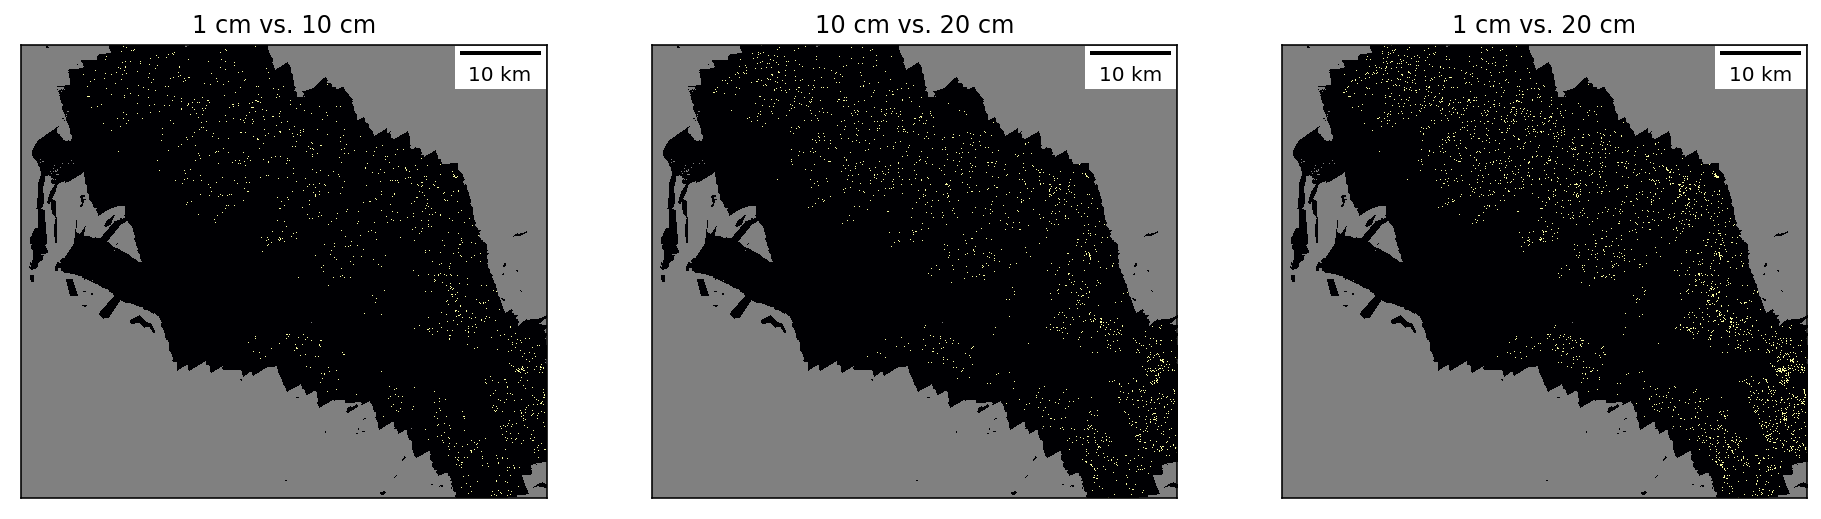

In [145]:
f,axa = plt.subplots(1,3, figsize=(16,10), sharex=True, sharey=True)
imshow_stretch(axa[0], snow_mask_01cm_10cm, clim=(0,1), cbar=False)
axa[0].set_title('1 cm vs. 10 cm')
imshow_stretch(axa[1], snow_mask_10cm_20cm, clim=(0,1), cbar=False)
axa[1].set_title('10 cm vs. 20 cm')
imshow_stretch(axa[2], snow_mask_01cm_20cm, clim=(0,1), cbar=False)
axa[2].set_title('1 cm vs. 20 cm')

## Analysis

We assessed a broad range of thresholds to determine the sensitivity of ASO-derived snow covered area to choice of threshold. [Raleigh and Small, 2017)][rs] suggest a range of vertical accuracy of lidar-based snow depth measurements between 2-30 cm, so we chose to evaluate a subset ranging from 1 cm to 20 cm. 

We observed a **9.28% difference in SCA** across the widest range of thresholds (e.g. comparing 1 cm to 20 cm). This amounts to a difference of $4660217$ pixels, which represents $\mathrm{41.9 km}^2$. 

We also evaluated several specific thresholds and their relationships to one another. [Painter et al., 2016][painter16] suggest an 8 cm vertical accuracy for Airborne Snow Observatory-derived snow depth measurements, based on an assessment of open (e.g. unforested) terrain without topographic complexity. [Currier et al., 2016], when comparing ALS snow depth to both terrestrial lidar and ground-based snow probe surveys at open and forested sites, observed a range of vertical RMSD values between 8 cm and 16 cm. 

Our assessment of this literature motivated the comparison of **2 cm, 8 cm, 10 cm, and 20 cm** thresholds. Focusing our attention on the center of the known vertical accuracy range, we found small differences in SCA between 8 cm and 10 cm (**0.97% SCA difference, 4.43 km$^2$**). 

Taking into account the homogeneous nature of the Tuolumne watershed studied here, particularly with regard to topogrpahic complexity and forested regions, we believe a 10 cm is the threshold value that takes into account these sources of uncertainty present in this watershed while still being representative of our current understanding of ALS vertical accuracy. 

[rs]: https://doi.org/10.1002/2016GL071999
[painter16]: https://doi.org/10.1016/j.rse.2016.06.018
[currier]: https://doi.org/10.1029/2018WR024533